<a href="https://colab.research.google.com/github/Myashka/MIPT_Applied_ML/blob/main/week_15_vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practice: VAE
_Reference_: based on [this demonstration of VAE in keras](https://github.com/msurtsukov/ae_vae_gan)

Today we will train a variational autoencoder on a MNIST dataset and see what properties does its latent space have.

## Setup

In [1]:
import sys
from base64 import b64encode

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
from scipy.stats import norm
from torch.utils.data import DataLoader
from torchsummary import summary
from torchvision import transforms
from torchvision.datasets import MNIST
from tqdm.auto import tqdm, trange


sns.set()


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
data_root = '.'
batch_size = 256

transform = transforms.ToTensor()

train_loader = DataLoader(
    dataset=MNIST(
        data_root,
        train=True,
        transform=transform,
        download=True,
    ),
    batch_size=batch_size,
    shuffle=True,
)

test_loader = DataLoader(
    dataset=MNIST(
        data_root,
        train=False,
        transform=transform,
        download=True,
    ),
    batch_size=batch_size,
    shuffle=True,
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting .\MNIST\raw\train-images-idx3-ubyte.gz to .\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting .\MNIST\raw\train-labels-idx1-ubyte.gz to .\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting .\MNIST\raw\t10k-images-idx3-ubyte.gz to .\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting .\MNIST\raw\t10k-labels-idx1-ubyte.gz to .\MNIST\raw



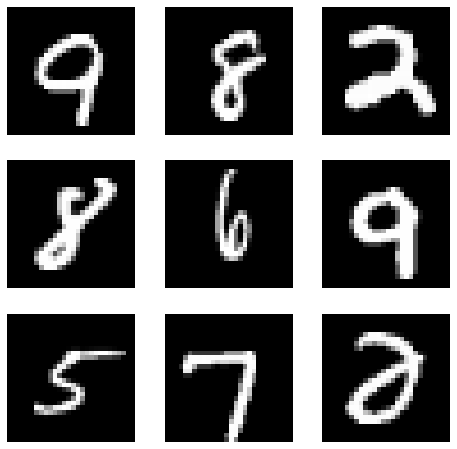

In [4]:
images, _ = next(iter(train_loader))
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for ax, image in zip(axes.flatten(), images):
    ax.imshow(image.squeeze().numpy(), cmap='gray')
    ax.grid(False)
    ax.set_axis_off()

plt.show()

## Defining our model

Autoencoder is a model that takes an image (or anything else for that matter) as input and tries to project it into a latent space with much lower dimensionality. Trick here is to be able to restore the original image afterwards, meaning that we were able to preserve all of the information. If we succeed in training such model, we could then use latent representations e.g. as dense embeddings for a discriminative model.

Variational autoencoders are just like autoencoders, however, with VAE, encoder predicts a location and scale for the distribution of latent representation of each item. This can be viewed as an additional normalization on our latent space. The only problem here is that now during the training phase, we need to sample from normal distribution with parameters, that are determined by our network and this is not a diffirentiable operation. It turns out, however, that we can use a little something called *reparameterization trick*: we sample some $z \sim \mathcal{N}(0, 1)$ and multiply it by the predicted $\sigma_i$ and add $\mu_i$. This produces the new variable $y = z \sigma_i + \mu_i$ which has exactly the distribution we need, yet the actual sampling is done outside the computational graph.

In [27]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, intermediate_dims, latent_dim, image_shape, dropout=0.3):
        super().__init__()

        in_features = np.prod(image_shape)
        encoder_modules = [nn.Flatten()]
        for out_features in intermediate_dims:
            encoder_modules.append(nn.Linear(in_features, out_features))
            encoder_modules.append(nn.ReLU())
            encoder_modules.append(nn.BatchNorm1d(out_features))
            encoder_modules.append(nn.Dropout(dropout))

            in_features = out_features

        self.encoder = nn.Sequential(*encoder_modules)

        # YOUR CODE HERE
        self.latent_mu = nn.Linear(in_features, latent_dim)
        self.latent_log_sigma = nn.Linear(in_features, latent_dim)

        in_features = latent_dim
        decoder_modules = []
        for out_features in reversed(intermediate_dims):
            decoder_modules.append(nn.Linear(in_features, out_features))
            decoder_modules.append(nn.LeakyReLU())
            decoder_modules.append(nn.BatchNorm1d(out_features))
            decoder_modules.append(nn.Dropout(dropout))

            in_features = out_features

        out_features = np.prod(image_shape)
        
        decoder_modules.append(nn.Linear(in_features, out_features))

        # To force output values to be in range from 0 to 1
        decoder_modules.append(nn.Sigmoid())
        decoder_modules.append(nn.Unflatten(dim=1, unflattened_size=image_shape))
        self.decoder = nn.Sequential(*decoder_modules)

    def reparametrize(self, sample, mu, log_sigma):
        # YOUR CODE HERE
        latent_sample = torch.exp(log_sigma/2) * sample + mu

        return latent_sample

    def forward(self, x):
        encoded = self.encoder(x)
        latent_mu = self.latent_mu(encoded)
        latent_log_sigma = self.latent_log_sigma(encoded)

        sample = torch.randn_like(latent_mu)
        latent_sample = self.reparametrize(sample, latent_mu, latent_log_sigma)

        reconstructed = self.decoder(latent_sample)
        return reconstructed, latent_sample, latent_mu, latent_log_sigma

In [28]:
images = images.to(device)
image_shape = images[0].shape
latent_dim = 2

model = VariationalAutoEncoder(
    intermediate_dims=[256, 128],
    latent_dim=latent_dim,
    image_shape=image_shape,
).to(device)
optimizer = torch.optim.Adam(model.parameters())

reconstructed, latent_sample, mu, log_sigma = model(images)
summary(model, image_shape)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 128]                 --
|    └─Flatten: 2-1                      [-1, 784]                 --
|    └─Linear: 2-2                       [-1, 256]                 200,960
|    └─ReLU: 2-3                         [-1, 256]                 --
|    └─BatchNorm1d: 2-4                  [-1, 256]                 512
|    └─Dropout: 2-5                      [-1, 256]                 --
|    └─Linear: 2-6                       [-1, 128]                 32,896
|    └─ReLU: 2-7                         [-1, 128]                 --
|    └─BatchNorm1d: 2-8                  [-1, 128]                 256
|    └─Dropout: 2-9                      [-1, 128]                 --
├─Linear: 1-2                            [-1, 2]                   258
├─Linear: 1-3                            [-1, 2]                   258
├─Sequential: 1-4                        [-1, 1, 28, 28]           --
| 

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 128]                 --
|    └─Flatten: 2-1                      [-1, 784]                 --
|    └─Linear: 2-2                       [-1, 256]                 200,960
|    └─ReLU: 2-3                         [-1, 256]                 --
|    └─BatchNorm1d: 2-4                  [-1, 256]                 512
|    └─Dropout: 2-5                      [-1, 256]                 --
|    └─Linear: 2-6                       [-1, 128]                 32,896
|    └─ReLU: 2-7                         [-1, 128]                 --
|    └─BatchNorm1d: 2-8                  [-1, 128]                 256
|    └─Dropout: 2-9                      [-1, 128]                 --
├─Linear: 1-2                            [-1, 2]                   258
├─Linear: 1-3                            [-1, 2]                   258
├─Sequential: 1-4                        [-1, 1, 28, 28]           --
| 

In [29]:
images.shape

torch.Size([96, 1, 28, 28])

Apart from minimizing the distance between input and the reconstruction, we want to push our latent representations to the origin of coordinates. We do so by adding second term to loss. This second term is KL divergence between our latent distributions and standard normal. We can compute this using the following formula:

$$ D_{KL}(\mu_i, \sigma_i^2) = \frac12 \left[ \left( \sum_i \mu_i^2 + \sum_i \sigma_i^2 \right) - \sum_i (\log \sigma_i^2 + 1) \right] $$

In [30]:
def kl_loss(mu, log_sigma):
    # YOUR CODE HERE
    # return ...
    sigma = torch.exp(log_sigma)
    return 0.5 * torch.mean(
        torch.sum(mu * mu + sigma - 2 * log_sigma - 1, dim=1)
    )


kl_loss(mu, log_sigma)

tensor(0.6840, device='cuda:0', grad_fn=<MulBackward0>)

In [31]:
def get_test_predictions(model, test_loader):
    reconstructed_batches = []
    latent_sample_batches = []
    mu_batches = []
    log_sigma_batches = []

    model.eval()
    with torch.no_grad():
        for images, _ in tqdm(test_loader, leave=False):
            images = images.to(device)
            reconstructed, latent_sample, mu, log_sigma = model(images)
            reconstructed_batches.append(reconstructed.cpu())
            latent_sample_batches.append(latent_sample.cpu())
            mu_batches.append(mu.cpu())
            log_sigma_batches.append(log_sigma.cpu())

    reconstructed = torch.cat(reconstructed_batches, dim=0)
    latent_sample = torch.cat(latent_sample_batches, dim=0)
    mu = torch.cat(mu_batches, dim=0)
    log_sigma = torch.cat(log_sigma_batches, dim=0)
    return reconstructed, latent_sample, mu, log_sigma

In [32]:
reconstructed, latent_sample, mu, log_sigma = get_test_predictions(model, test_loader)

  0%|          | 0/40 [00:00<?, ?it/s]

In [33]:
# Generate manifold of (n_steps x n_steps) images.
n_steps = 15

grid_x = norm.ppf(np.linspace(0.05, 0.95, n_steps))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n_steps))


def draw_manifold(model):
    model.eval()
    _, image_height, image_width = image_shape
    manifold = np.zeros((image_height * n_steps, image_width * n_steps))
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            latent_sample = torch.tensor([[xi, yi]]).float().to(device)

            with torch.no_grad():
                reconstructed = model.decoder(latent_sample).cpu().numpy()

            digit = reconstructed.squeeze()
            manifold[
                i * image_height : (i + 1) * image_height, j * image_width : (j + 1) * image_width
            ] = digit

    return manifold

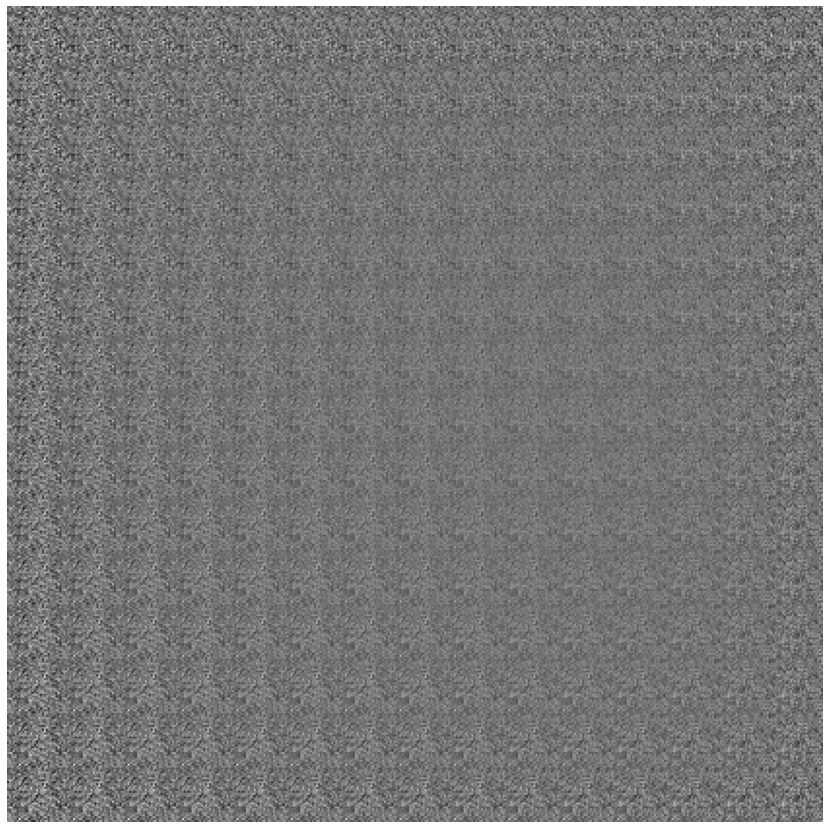

In [34]:
model.eval()
manifold = draw_manifold(model)

plt.figure(figsize=(15, 15))
plt.imshow(manifold, cmap='gray')
plt.axis('off')
plt.show()

In [35]:
n_epochs = 46
epochs, manifolds, latent_distributions = [], [], []
bce_loss = F.binary_cross_entropy
for epoch in trange(n_epochs):
    model.train()
    train_loss = 0.0
    train_bce = 0.0
    train_kl = 0.0
    for images, _ in tqdm(train_loader, leave=False):
        images = images.to(device)
        reconstructed, latent_sample, mu, log_sigma = model(images)

        bce = bce_loss(reconstructed, images)
        kl = kl_loss(mu, log_sigma)
        loss = bce + 1e-3 * kl

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_bce += bce.item()
        train_kl += kl.item()

    train_loss /= len(train_loader)
    train_bce /= len(train_loader)
    train_kl /= len(train_loader)

    if epoch % 5 == 0:
        print(f'epoch {epoch}: loss={train_loss:.4f}, kl={train_kl:.4f}, bce={train_bce:.4f}')

        epochs.append(epoch)

        model.eval()
        manifold = draw_manifold(model)
        manifolds.append(manifold)

        _, _, mu, _ = get_test_predictions(model, test_loader)
        latent_distributions.append(mu)

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

epoch 0: loss=0.3995, kl=5.3665, bce=0.3942


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

epoch 5: loss=0.2151, kl=8.8324, bce=0.2063


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

epoch 10: loss=0.2104, kl=9.3769, bce=0.2010


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

epoch 15: loss=0.2070, kl=9.7422, bce=0.1973


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

epoch 20: loss=0.2058, kl=9.8769, bce=0.1960


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

epoch 25: loss=0.2045, kl=9.9953, bce=0.1945


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

epoch 30: loss=0.2034, kl=10.0430, bce=0.1933


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

epoch 35: loss=0.2028, kl=10.1082, bce=0.1927


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

epoch 40: loss=0.2021, kl=10.1221, bce=0.1920


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

epoch 45: loss=0.2019, kl=10.1906, bce=0.1917


  0%|          | 0/40 [00:00<?, ?it/s]

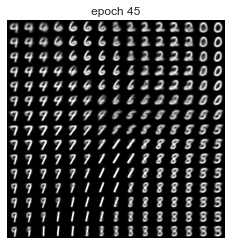

In [36]:
fig = plt.figure()
image_display = plt.imshow(manifolds[0], cmap='gray')
plt.title(f"epoch {epochs[0]}")


def update(i):
    image_display.set_array(manifolds[i])
    image_display.axes.set_title(f"epoch {epochs[i]}")
    image_display.axes.axis('off')
    return image_display


anim = FuncAnimation(fig, update, frames=range(len(manifolds)), interval=100)
anim.save('manifold.mp4', writer='ffmpeg', fps=5)

In [14]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

video_path = 'manifold.mp4'  # You can also try other indices

if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with open(video_path, 'rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML(
    """
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(
        data_url
    )
)

C:\Users\porsh\AppData\Local\Temp\ipykernel_25692\2426164446.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


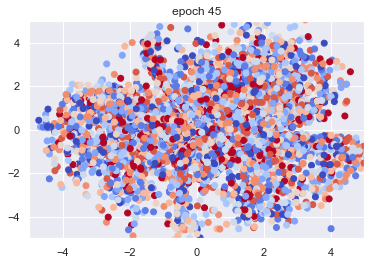

In [37]:
test_labels = torch.cat([labels for _, labels in test_loader], dim=0).numpy()
fig = plt.figure()
plt.scatter(
    latent_distributions[0][:, 0],
    latent_distributions[0][:, 1],
    c=test_labels,
    cmap='coolwarm',
)
plt.colorbar()
plt.title(f"epoch {epochs[0]}")


def update(i):
    fig.clear()
    plot = plt.scatter(
        latent_distributions[i][:, 0],
        latent_distributions[i][:, 1],
        c=test_labels,
        cmap='coolwarm',
    )
    fig.gca().set_title(f"epoch {epochs[i]}")
    fig.gca().set_xlim(-5, 5)
    fig.gca().set_ylim(-5, 5)
    return plot


anim = FuncAnimation(fig, update, frames=range(len(latent_distributions)), interval=150)
anim.save('distribution.mp4', dpi=80, writer='ffmpeg', fps=5)

In [38]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

video_path = 'distribution.mp4'  # You can also try other indices

if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with open(video_path, 'rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML(
    """
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(
        data_url
    )
)

You can find your brand animations in current directory ;)